In [12]:
import geopandas as gpd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
from shapely.geometry import Polygon
from pyproj import CRS
import json
from shapely.geometry import shape
import os


In [13]:

# Chemins d'accès au GeoJSON de la France et à l'image JPG
geojson_path = r"C:\Users\nadim\Desktop\ttair\data\image\data\test.geojson"
image_path = r'C:\Users\nadim\Desktop\ttair\data\image\maxj\PM25\PREVAIR.analyse.20230702.MAXJ.PM25.public.jpg'
image_path_output = r'C:\Users\nadim\Desktop\ttair\data\image\maxj\PM25\PREVAIR.analyse.20230702.MAXJ.PM25.public_output.jpg'

folder = r"C:\Users\nadim\Desktop\ttair\data\image\data"

image_tif = folder + r"\image_output.tif"

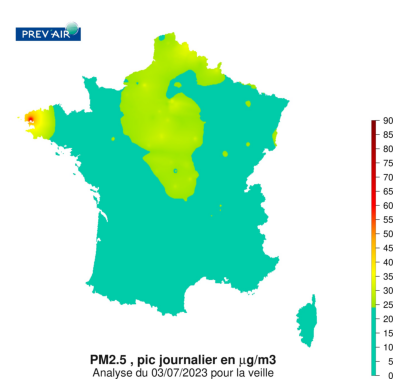

In [14]:
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

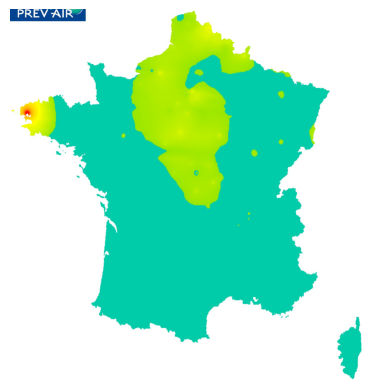

'C:\\Users\\sofia\\Desktop\\4iabd\\pa\\data\\image\\maxj\\PM25\\PREVAIR.analyse.20230702.MAXJ.PM25.public_output.jpg'

In [15]:
# Define the bounding box for the crop
left = 33
top = 119
right = 1707
bottom = 1880

# Crop the image
img_cropped = img.crop((left, top, right, bottom))

# Display the cropped image
plt.imshow(img_cropped)
plt.axis('off')
plt.show()
# Save the cropped image

img_cropped.save(image_path_output)

image_path_output




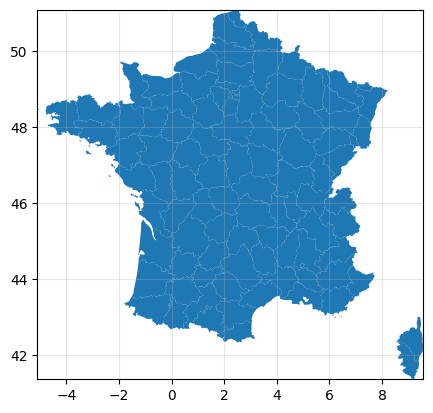

In [16]:

# Charger le GeoJSON en tant que GeoDataFrame
gdf = gpd.read_file(geojson_path)

# Tracer les entités géographiques
#gdf.plot()

# Obtenir les limites géographiques (boîte englobante)
bounds = gdf.total_bounds

# Créer le graphique
fig, ax = plt.subplots()

# Tracer les entités géographiques sur l'axe du graphique
gdf.plot(ax=ax)

# Définir les limites de l'axe du graphique en utilisant les limites géographiques
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Activer la grille avec une transparence de 0.3
ax.grid(True, alpha=0.3)

# Afficher le graphique
plt.show()

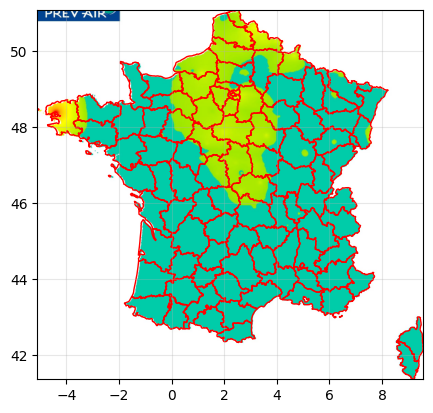

In [17]:

gdf = gpd.read_file(geojson_path)

# Lire l'image
#image_path = r"C:\Users\nadim\Desktop\ttair\data\image\moyj\test2\PREVAIR.analyse.20230601.MOYJ.PM25.public.jpg"

img = Image.open(image_path_output)

# Transformer l'image en un tableau numpy pour une manipulation facile
img_array = np.array(img)

# Obtenir les limites du GeoJSON
bounds = gdf.total_bounds

# Créer une figure et des axes
fig, ax = plt.subplots()

# Afficher l'image en arrière-plan avec l'étendue correspondant aux limites du GeoJSON
ax.imshow(img_array, extent=[bounds[0], bounds[2], bounds[1], bounds[3]])

# Tracer le GeoJSON par dessus l'image
gdf.plot(ax=ax, facecolor='none', edgecolor='red')

# Définir les limites des axes
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Activer la grille
ax.grid(True, alpha=0.3)

# Afficher le graphique
plt.show()


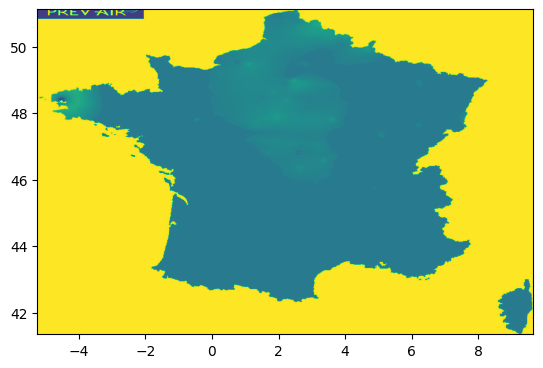

Système de référence de coordonnées (CRS) : EPSG:4326
Transformation affine :
 | 0.01, 0.00,-5.25|
| 0.00,-0.01, 51.12|
| 0.00, 0.00, 1.00|
Coordonnées géographiques du pixel (500, 500) : -0.7921415770609324 47.233637137989774


In [18]:


# Définir les coordonnées de la bbox
bbox = {
    "type": "Polygon",
    "coordinates": [
        [
            [-5.25, 41.35],
            [9.66, 41.35],
            [9.66, 51.12],
            [-5.25, 51.12],
            [-5.25, 41.35]
        ]
    ]
}

# Créer un objet de géométrie Polygon à partir des coordonnées de la bbox
polygon = Polygon(bbox["coordinates"][0])

# Définir la projection spatiale (CRS) de la bbox (WGS84)
crs = CRS.from_epsg(4326)

# Ouvrir le fichier JPEG avec Matplotlib pour visualiser l'image
image = plt.imread(image_path_output)

# Convertir l'image en niveaux de gris
gray_image = image.mean(axis=2)

# Créer le profil (métadonnées) pour le nouveau fichier TIFF géoréférencé
profile = {
    'driver': 'GTiff',
    'dtype': rasterio.float32,
    'width': gray_image.shape[1],
    'height': gray_image.shape[0],
    'count': 1,  # Un seul canal (niveaux de gris)
    'crs': crs,
    'transform': rasterio.transform.from_bounds(*polygon.bounds, width=gray_image.shape[1], height=gray_image.shape[0]),
}

# Créer un masque booléen basé sur la bbox
mask = geometry_mask([polygon], out_shape=(gray_image.shape[0], gray_image.shape[1]), transform=profile['transform'], invert=True)

# Appliquer le masque à l'image en niveaux de gris
masked_image = gray_image * mask.astype(rasterio.float32)

# Enregistrer le nouveau fichier TIFF géoréférencé
output_tiff_path = folder + 'nouveau_fichier.tif'
with rasterio.open(output_tiff_path, 'w', **profile) as dst:
    dst.write(masked_image, 1)  # Écrire l'image dans le canal 1

# Afficher l'image résultante avec la bbox
with rasterio.open(output_tiff_path) as new_src:
    show(new_src)
    
# Ouvrez le fichier TIFF en mode lecture
with rasterio.open(output_tiff_path, "r+") as ds:
    # Affiche les informations de géoréférencement
    print("Système de référence de coordonnées (CRS) :", ds.crs)
    print("Transformation affine :\n", ds.transform)
    
# Ouvrir le fichier TIFF en mode lecture
with rasterio.open(output_tiff_path, "r+") as ds:
    # Convertir les coordonnées du pixel (500, 500) en coordonnées géographiques
    lon, lat = ds.xy(700, 500)

# Afficher les coordonnées géographiques
print("Coordonnées géographiques du pixel (500, 500) :"
      , lon, lat)



In [29]:
import json
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
from shapely.geometry import shape

# Ouvrir le fichier TIFF en mode lecture
with rasterio.open(output_tiff_path) as ds:
    # Charger le GeoJSON du polygone du département 95
    geojson_path = r"C:\Users\nadim\Desktop\ttair\data\image\data\test.geojson"
    with open(geojson_path) as f:
        geojson_data = json.load(f)

    # Convertir le GeoJSON en géométrie Shapely
    polygon = shape(geojson_data['features'][0]['geometry'])

    # Obtenir les indices des pixels inclus dans le polygone
    mask = geometry_mask([polygon], out_shape=ds.shape, transform=ds.transform, invert=False)

    # Lire les valeurs des pixels inclus dans le polygone
    image_data = ds.read(1, masked=True)
    pixels_in_polygon = image_data[mask]

    # Afficher les valeurs des pixels
    print("Valeurs des pixels inclus dans le polygone du département 95 :", pixels_in_polygon)


Valeurs des pixels inclus dans le polygone du département 95 : [ 70.666664  70.666664  70.666664 ... 255.       255.       255.      ]


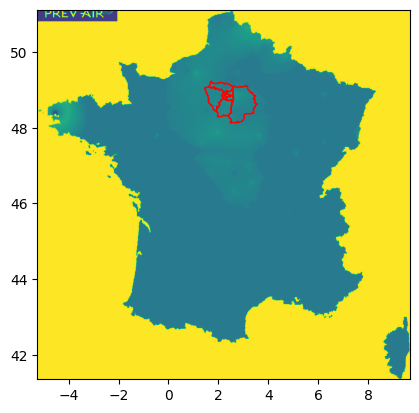

In [33]:
# Open the TIFF file in read mode
with rasterio.open(output_tiff_path) as ds:
    # Load all departments from the GeoJSON file
    ile_de_france_codes = ['75', '77', '78', '91', '92', '93', '94', '95']

# Load the GeoJSON file as a GeoDataFrame
    departments = gpd.read_file(geojson_path)
    ile_de_france = departments[departments['code'].isin(ile_de_france_codes)]

    # Display the image with the polygons using geopandas and rasterio
    fig, ax = plt.subplots()
    show(ds, ax=ax)
    ile_de_france.plot(ax=ax, facecolor='none', edgecolor='red')

    plt.show()
    
    # Create a plot


# Plot the boundaries of the departments of Île-de-France


In [ ]:
# Define the department codes for Île-de-France
ile_de_france_codes = ['75', '77', '78', '91', '92', '93', '94', '95']

# Load the GeoJSON file as a GeoDataFrame
departments = gpd.read_file(geojson_path)

# Filter the GeoDataFrame to keep only the departments of Île-de-France
ile_de_france = departments[departments['code'].isin(ile_de_france_codes)]

# Create a plot
fig, ax = plt.subplots()

# Plot the boundaries of the departments of Île-de-France
ile_de_france.boundary.plot(ax=ax, color='red')

# Show the plot
plt.show()

In [25]:
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
from shapely.geometry import shape

# Ouvrir le fichier TIFF en mode lecture
with rasterio.open(output_tiff_path) as ds:
    # Charger le GeoJSON du polygone du département 95
    geojson_path = r"C:\Users\nadim\Desktop\ttair\data\image\data\test.geojson"
    with open(geojson_path) as f:
        geojson_data = json.load(f)

    # Convertir le GeoJSON en géométrie Shapely
    polygon = shape(geojson_data['features'][0]['geometry'])

    # Obtenir les indices des pixels inclus dans le polygone
    mask = geometry_mask([polygon], out_shape=ds.shape, transform=ds.transform, invert=False)

    # Lire les valeurs des pixels inclus dans le polygone
    values = ds.sample(mask)

    # Afficher les valeurs des pixels
    print("Valeurs des pixels inclus dans le polygone du département 95 :", values)


Valeurs des pixels inclus dans le polygone du département 95 : <generator object sample_gen at 0x000001521B6DDBD0>


Couleurs des pixels inclus dans le polygone du département 95 : [[[ 70.666664]
  [ 70.666664]
  [ 70.666664]
  ...
  [255.      ]
  [255.      ]
  [255.      ]]

 [[ 70.666664]
  [ 70.666664]
  [ 70.666664]
  ...
  [255.      ]
  [255.      ]
  [255.      ]]

 [[ 70.666664]
  [ 70.666664]
  [ 70.666664]
  ...
  [255.      ]
  [255.      ]
  [255.      ]]

 ...

 [[255.      ]
  [255.      ]
  [255.      ]
  ...
  [255.      ]
  [255.      ]
  [255.      ]]

 [[255.      ]
  [255.      ]
  [255.      ]
  ...
  [255.      ]
  [255.      ]
  [255.      ]]

 [[255.      ]
  [255.      ]
  [255.      ]
  ...
  [255.      ]
  [255.      ]
  [255.      ]]]


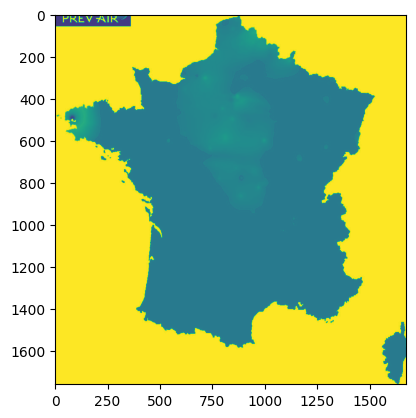

In [28]:
import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import geometry_mask
from shapely.geometry import shape

# Ouvrir le fichier TIFF en mode lecture
with rasterio.open(output_tiff_path) as ds:
    # Charger le GeoJSON du polygone du département 95
    geojson_path = r"C:\Users\nadim\Desktop\ttair\data\image\data\test.geojson"
    with open(geojson_path) as f:
        geojson_data = json.load(f)

    # Convertir le GeoJSON en géométrie Shapely
    polygon = shape(geojson_data['features'][0]['geometry'])

    # Obtenir les indices des pixels inclus dans le polygone
    mask = geometry_mask([polygon], out_shape=ds.shape, transform=ds.transform, invert=False)
    indices = mask.nonzero()

    # Lire les valeurs des canaux de couleur RGB des pixels inclus dans le polygone
    pixel_values = ds.read(window=((indices[0].min(), indices[0].max()+1), (indices[1].min(), indices[1].max()+1)))

    # Réorganiser les dimensions de l'array pour obtenir la couleur RGB correcte
    rgb_values = reshape_as_image(pixel_values)

    # Afficher les couleurs des pixels
    print("Couleurs des pixels inclus dans le polygone du département 95 :", rgb_values)
    plt.imshow(rgb_values)
